In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Foods

/content/drive/My Drive/Foods


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
data_dir = '/content/drive/My Drive/Foods/data'

In [5]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2083


## Convert not supported extentions to jpg

In [ ]:
supported = ['jpg', 'png', 'jpeg', 'gif', 'bmp' ]
img_paths = list(data_dir.glob('*/*.jpg'))
unsupported_imgs = []
for p in img_paths:
    img = PIL.Image.open(p)
    if img.format.lower() not in supported:
        unsupported_imgs.append(p)
        print(img.format, p)

In [ ]:
for p in unsupported_imgs:
    img = PIL.Image.open(p)
    print(img.format, p)
    new_img = img.convert('RGB')
    new_img.save(p)
    print('Converted')

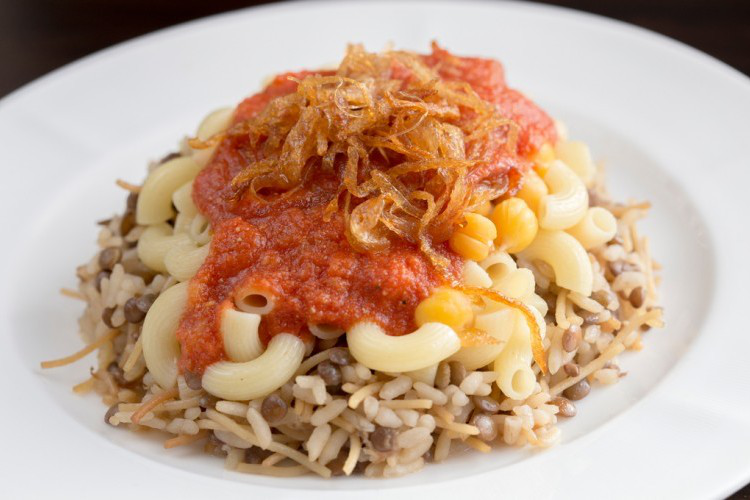

In [10]:
koshary = list(data_dir.glob('Koshary/*'))
PIL.Image.open(str(koshary[0]))

# Loading Data

In [7]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

In [8]:
class_names = ['Lentil soup', 'Fattah', 'Ful medames', 'Qatayef', 'Kanafeh', 'Koshary', 'Stuffed grape leaves', 'Molokhia', 'Om Ali', 'Rokak', 'Asabe zainab', 'Falafel']

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  class_names=class_names,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2083 files belonging to 12 classes.
Using 1667 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  class_names=class_names,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2083 files belonging to 12 classes.
Using 416 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['Lentil soup', 'Fattah', 'Ful medames', 'Qatayef', 'Kanafeh', 'Koshary', 'Stuffed grape leaves', 'Molokhia', 'Om Ali', 'Rokak', 'Asabe zainab', 'Falafel']


In [12]:
classes_len = len(class_names)

# Visualize the data

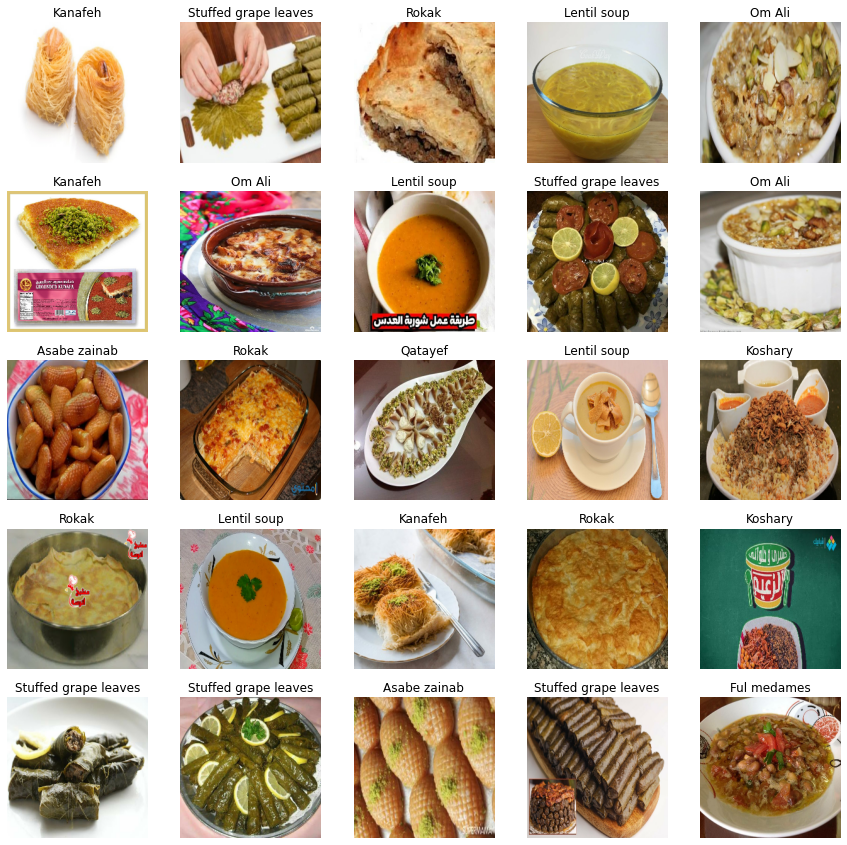

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(3000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Augmentation and Preprocessing

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

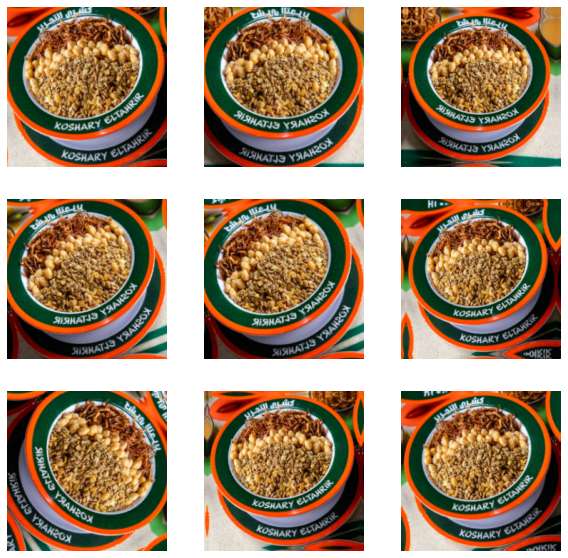

In [21]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [22]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Model

In [23]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [24]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


In [25]:
base_model.trainable = False

In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [27]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [28]:
prediction_layer = tf.keras.layers.Dense(classes_len, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 12)


In [29]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
base_learning_rate = 0.0001
# base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

2

# Training

In [33]:
initial_epochs = 15
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
27/27 [==============================] - 62s 2s/step - loss: 2.8007 - accuracy: 0.0984 - val_loss: 2.5146 - val_accuracy: 0.1226
Epoch 2/15
27/27 [==============================] - 3s 94ms/step - loss: 2.5026 - accuracy: 0.1458 - val_loss: 2.3135 - val_accuracy: 0.1827
Epoch 3/15
27/27 [==============================] - 3s 94ms/step - loss: 2.2674 - accuracy: 0.2346 - val_loss: 2.1382 - val_accuracy: 0.2524
Epoch 4/15
27/27 [==============================] - 3s 94ms/step - loss: 2.0999 - accuracy: 0.2939 - val_loss: 1.9786 - val_accuracy: 0.3293
Epoch 5/15
27/27 [==============================] - 3s 94ms/step - loss: 1.9752 - accuracy: 0.3407 - val_loss: 1.8366 - val_accuracy: 0.3966
Epoch 6/15
27/27 [==============================] - 3s 94ms/step - loss: 1.7915 - accuracy: 0.4109 - val_loss: 1.7062 - val_accuracy: 0.4784
Epoch 7/15
27/27 [==============================] - 3s 94ms/step - loss: 1.6525 - accuracy: 0.4679 - val_loss: 1.5975 - val_accuracy: 0.5144
Epoch 8/15
27/

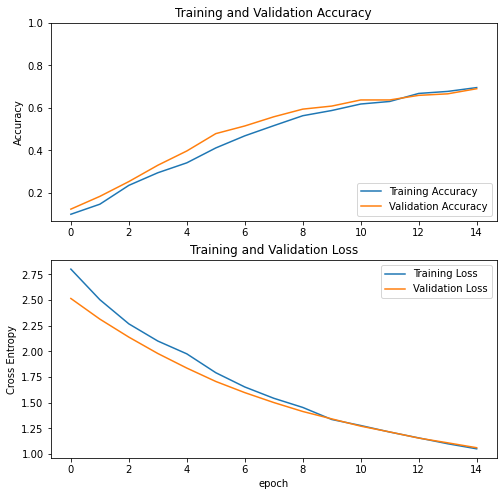

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
model.evaluate(val_ds)

7/7 [==============================] - 1s 72ms/step - loss: 1.0608 - accuracy: 0.6899


[1.0608311891555786, 0.6899038553237915]

# Fine Tuning

In [36]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [37]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [39]:
len(model.trainable_variables)

56

In [40]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 15/40
27/27 [==============================] - 10s 160ms/step - loss: 0.8305 - accuracy: 0.7289 - val_loss: 0.7118 - val_accuracy: 0.7909
Epoch 16/40
27/27 [==============================] - 3s 128ms/step - loss: 0.6284 - accuracy: 0.8050 - val_loss: 0.6141 - val_accuracy: 0.8029
Epoch 17/40
27/27 [==============================] - 3s 128ms/step - loss: 0.5640 - accuracy: 0.8188 - val_loss: 0.5753 - val_accuracy: 0.8101
Epoch 18/40
27/27 [==============================] - 3s 128ms/step - loss: 0.5215 - accuracy: 0.8296 - val_loss: 0.5047 - val_accuracy: 0.8317
Epoch 19/40
27/27 [==============================] - 3s 133ms/step - loss: 0.4637 - accuracy: 0.8488 - val_loss: 0.4831 - val_accuracy: 0.8317
Epoch 20/40
27/27 [==============================] - 3s 128ms/step - loss: 0.4148 - accuracy: 0.8614 - val_loss: 0.4301 - val_accuracy: 0.8558
Epoch 21/40
27/27 [==============================] - 3s 129ms/step - loss: 0.3926 - accuracy: 0.8716 - val_loss: 0.4073 - val_accuracy: 0.865

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

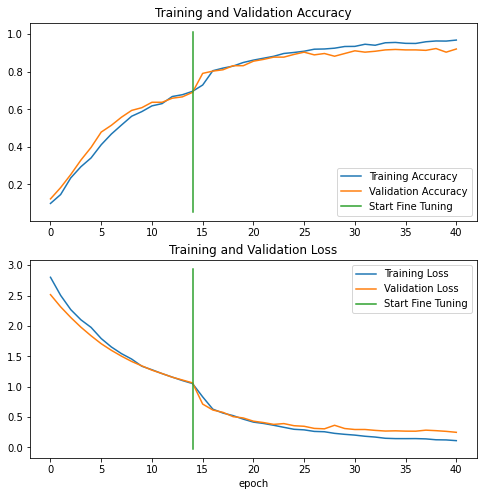

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
model.evaluate(val_ds)

7/7 [==============================] - 1s 71ms/step - loss: 0.2467 - accuracy: 0.9207


[0.24665190279483795, 0.9206730723381042]

In [44]:
model.evaluate(train_ds)

27/27 [==============================] - 2s 71ms/step - loss: 0.0697 - accuracy: 0.9838


[0.06971221417188644, 0.9838032126426697]

In [45]:
model.save('model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Confusion Matrix

In [46]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
%matplotlib inline

def plot_confusion_matrix(true_labels, predictions, class_names):
  data = confusion_matrix(true_labels, predictions)
  df_cm = pd.DataFrame(data, columns=class_names, index = class_names)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (15,15))
  sn.set(font_scale=1.4) # label's size
  sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})

## Train

In [47]:
predictions = np.array([])
true_labels =  np.array([])
for x, y in train_ds:
  batch_scores = model.predict(x)
  predictions = np.concatenate([predictions, np.argmax(batch_scores, axis=-1)])
  true_labels = np.concatenate([true_labels, y.numpy()])

In [49]:
flase_ids = (predictions != true_labels)
print(np.sum(flase_ids), 'wrong labels out of', len(flase_ids))

27 wrong labels out of 1667


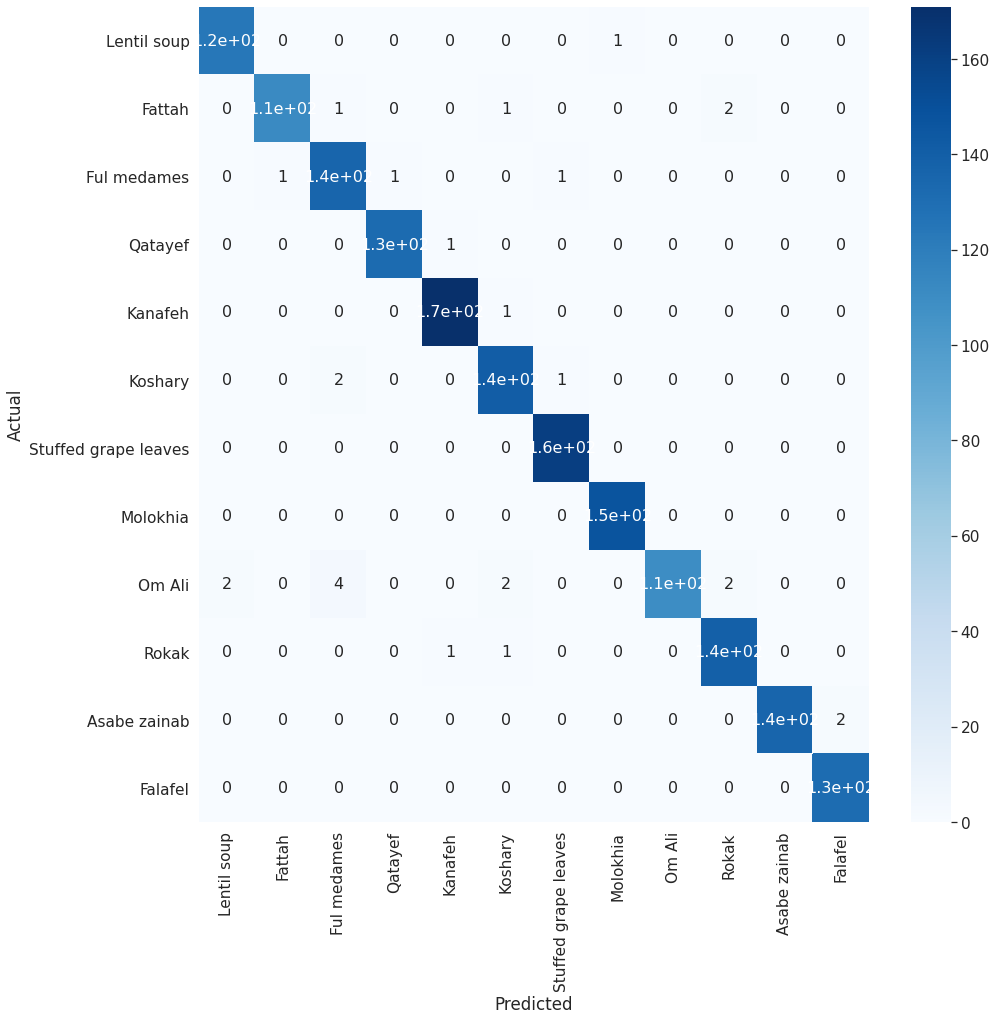

In [48]:
plot_confusion_matrix(true_labels, predictions, class_names)

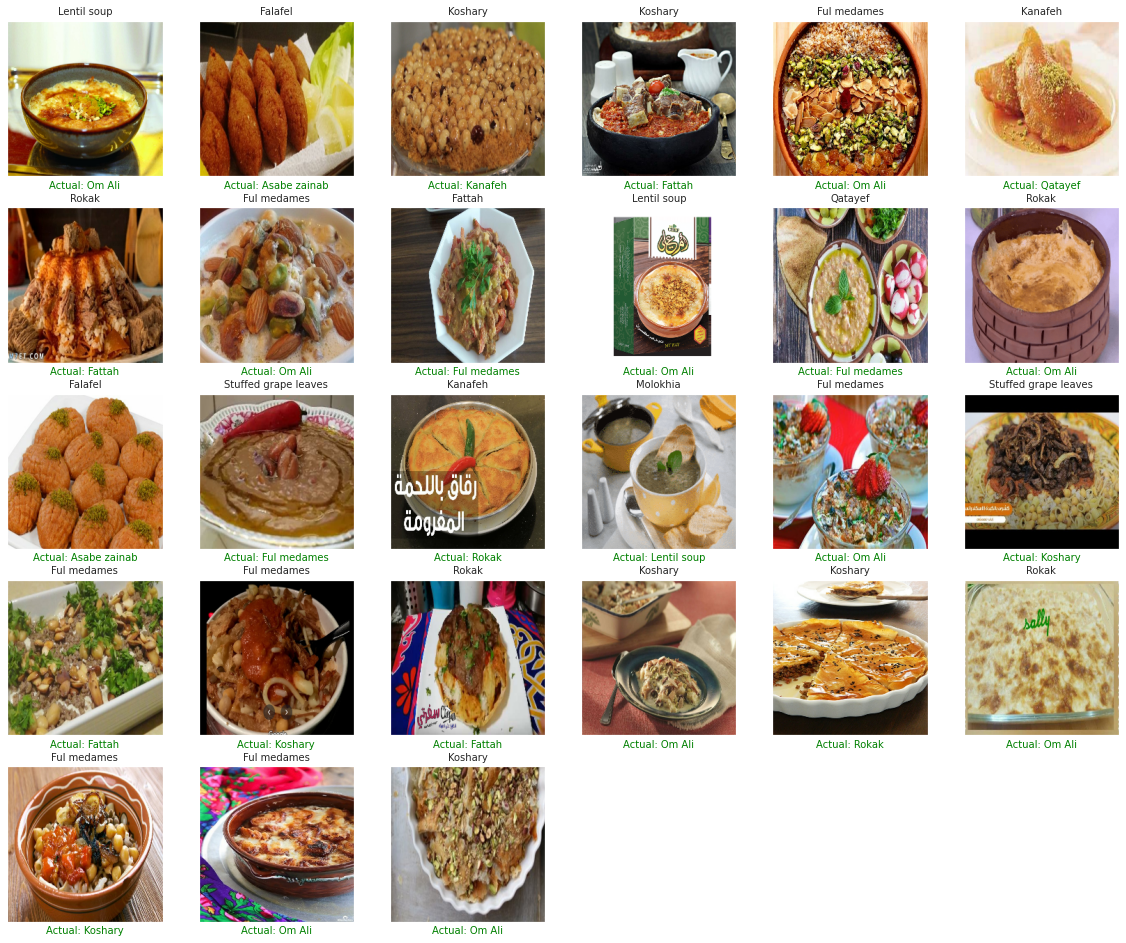

In [50]:
# TRAIN
imgs_len = np.sum(flase_ids)
dim = int( np.sqrt(imgs_len) ) + 1

plt.figure(figsize=(20, 20))
counter_plot = 0

for images, labels in train_ds:
  b_size = labels.numpy().size
  preds = np.argmax(model.predict(images), axis=-1)
  for i in range(b_size):
    if int(preds[i]) == labels[i].numpy():
      continue
      
    counter_plot += 1
    ax = plt.subplot(dim, dim, counter_plot)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.xlabel('Actual: ' + class_names[labels[i]], color='green', fontsize=10)
    plt.title(class_names[ int(preds[i]) ], fontsize=10)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])

## Validation

In [51]:
predictions = np.array([])
true_labels =  np.array([])
for x, y in val_ds:
  batch_scores = model.predict(x)
  predictions = np.concatenate([predictions, np.argmax(batch_scores, axis=-1)])
  true_labels = np.concatenate([true_labels, y.numpy()])

In [52]:
flase_ids = (predictions != true_labels)
print(np.sum(flase_ids), 'wrong labels out of', len(flase_ids))

33 wrong labels out of 416


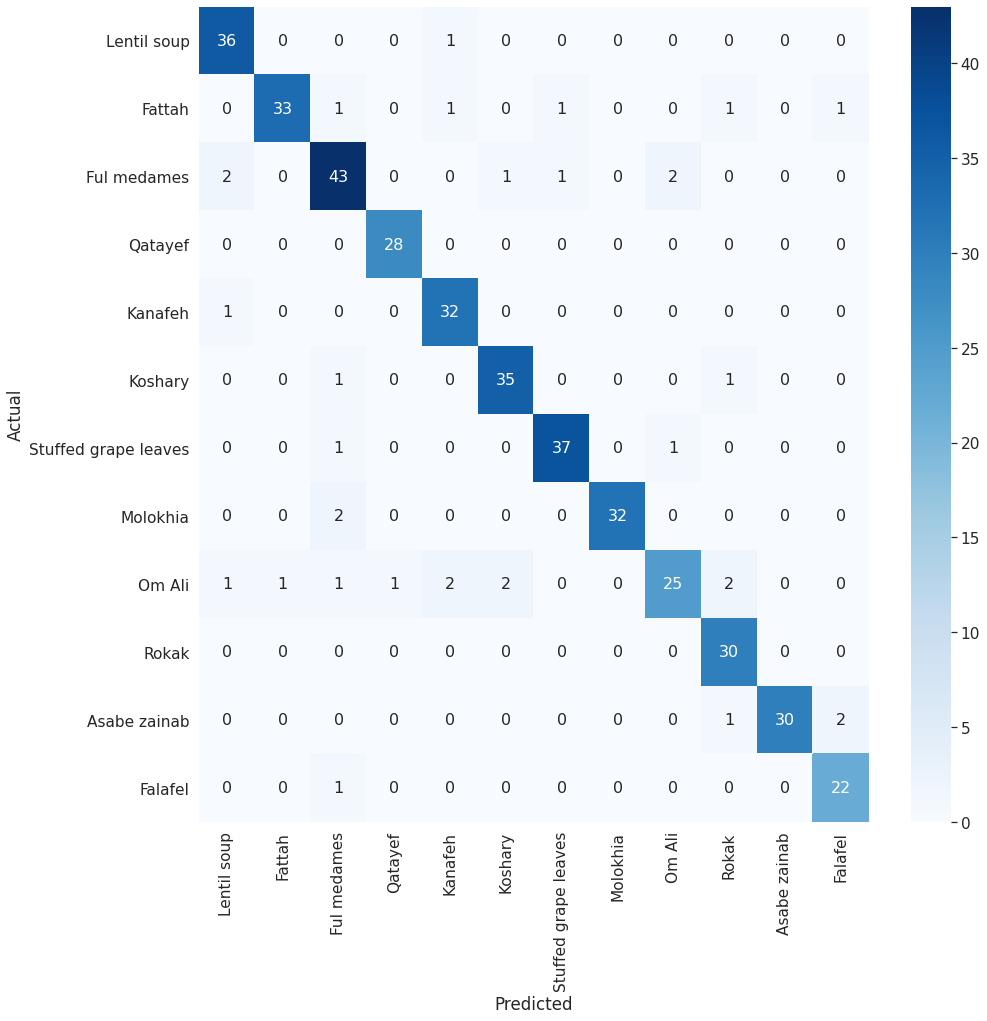

In [53]:
plot_confusion_matrix(true_labels, predictions, class_names)

In [55]:
# VAL
imgs_len = np.sum(flase_ids)
dim = int( np.sqrt(imgs_len) ) + 1

plt.figure(figsize=(20, 20))
or_index = - BATCH_SIZE
counter_plot = 0
for images, labels in val_ds:
  b_size = labels.numpy().size
  or_index += BATCH_SIZE
  for i in range(b_size):
    if flase_ids[or_index + i] == False:
      continue
    counter_plot += 1
    ax = plt.subplot(dim, dim, counter_plot)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.xlabel('Actual: ' + class_names[labels[i]], color='green', fontsize=10)
    assert(labels[i] == true_labels[or_index + i])
    plt.title(class_names[int( predictions[or_index + i] ) ], fontsize=10)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])

Output hidden; open in https://colab.research.google.com to view.